In [69]:
import numpy as np

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            mass = np.random.uniform(0.5, 10)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 20
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

Data point 1:
  Particle 1: [x = 0.866885, y = 0.653578, mass = 2.4519, force = [-7.224693e+01, -3.183962e+00]]
  Particle 2: [x = 0.055816, y = 0.782359, mass = 9.8418, force = [3.279758e+02, -7.028610e+02]]
  Particle 3: [x = 0.178690, y = 0.489596, mass = 7.7454, force = [-2.557289e+02, 7.060450e+02]]

Data point 2:
  Particle 1: [x = 0.585981, y = 0.541963, mass = 8.0636, force = [-1.931372e+02, -1.436113e+02]]
  Particle 2: [x = 0.414769, y = 0.229932, mass = 2.6434, force = [5.048745e+01, 1.774998e+02]]
  Particle 3: [x = 0.079916, y = 0.559582, mass = 3.5698, force = [1.426498e+02, -3.388851e+01]]

Data point 3:
  Particle 1: [x = 0.874757, y = 0.465720, mass = 1.6881, force = [-9.256684e+00, 2.534219e+01]]
  Particle 2: [x = 0.893176, y = 0.935370, mass = 2.5892, force = [-2.178243e+01, -2.306889e+01]]
  Particle 3: [x = 0.219591, y = 0.829603, mass = 3.8181, force = [3.103911e+01, -2.273299e+00]]



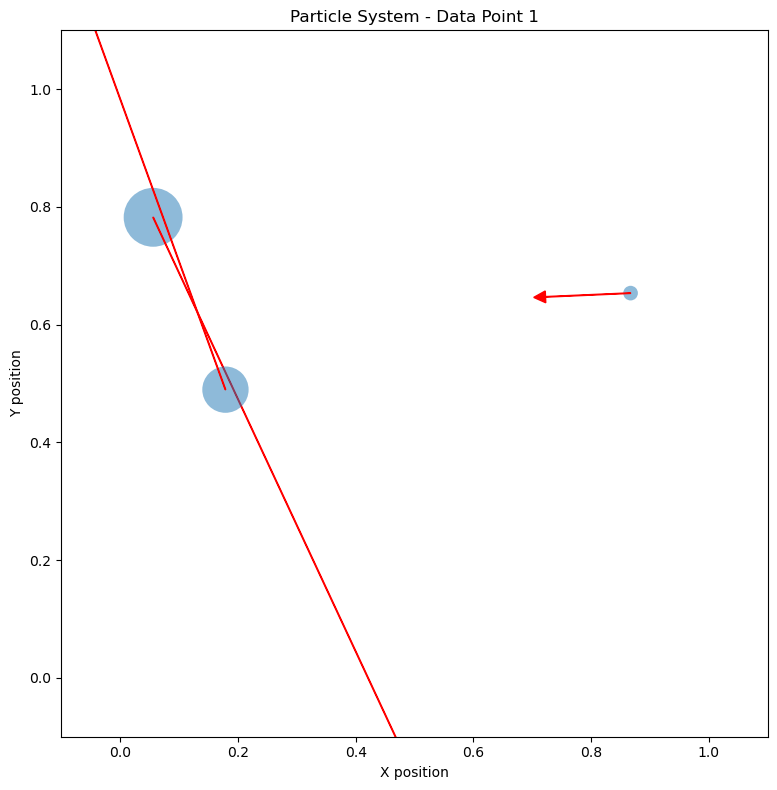

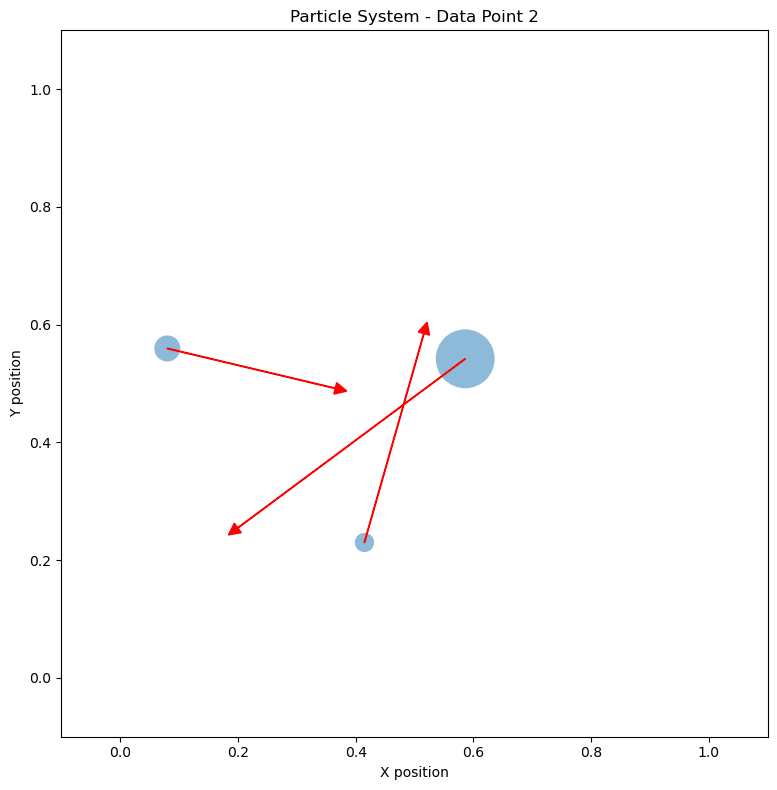

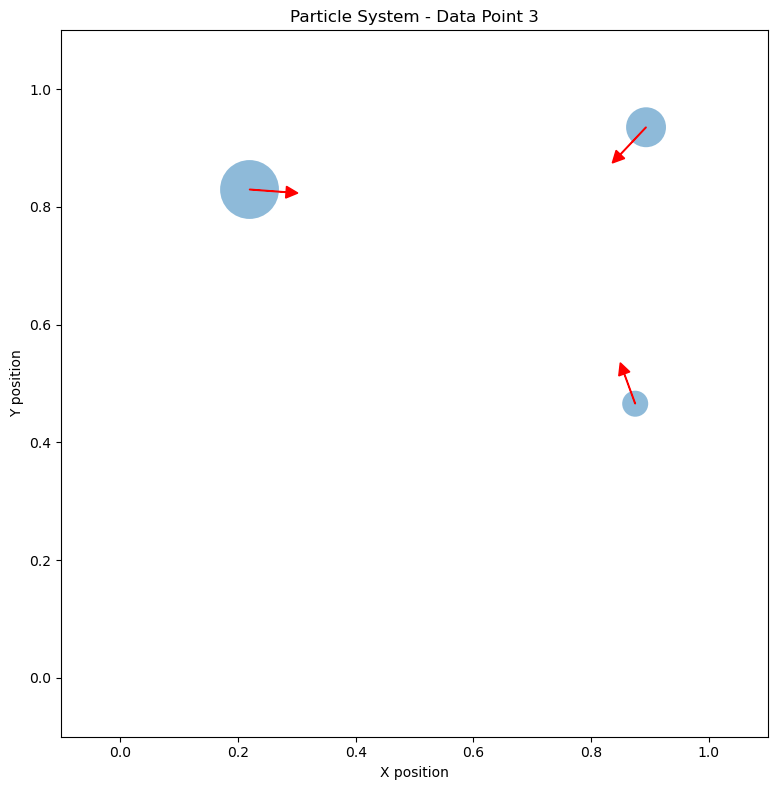

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        size = 50 * (mass / max_mass)  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=size/1000, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 1000),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.1059, 0.5419, 0.2864],
        [0.8455, 0.3536, 0.8343],
        [0.1597, 0.8625, 0.0317]])
Input:
tensor([[0.1059, 0.5419, 0.2864],
        [0.8455, 0.3536, 0.8343],
        [0.1597, 0.8625, 0.0317]])

Output (forces):
tensor([[0.1162, 0.2108],
        [0.1442, 0.2759],
        [0.1135, 0.2404]], grad_fn=<AddmmBackward0>)


In [72]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.8668847122740065, 0.6535777314391784, 2.4518530591867576, [-72.24693257279787, -3.1839620549429997]], [0.05581572050989947, 0.7823590894732108, 9.841775846114587, [327.97581855967223, -702.8610022197391]], [0.17868972969275387, 0.489595508422761, 7.745403918342691, [-255.72888598687433, 706.0449642746821]]]
[[0.5859808528797646, 0.5419626681740679, 8.063645095195291, [-193.1372002444736, -143.6112571255965]], [0.41476900475289047, 0.229932277510708, 2.6433750210958906, [50.48744720967629, 177.49976920064057]], [0.07991552661520618, 0.5595817331629871, 3.569774108077802, [142.64975303479733, -33.88851207504406]]]


tensor([[0.8669, 0.6536, 2.4519],
        [0.0558, 0.7824, 9.8418],
        [0.1787, 0.4896, 7.7454]])
tensor([[0.5860, 0.5420, 8.0636],
        [0.4148, 0.2299, 2.6434],
        [0.0799, 0.5596, 3.5698]])


tensor([[ -72.2469,   -3.1840],
        [ 327.9758, -702.8610],
        [-255.7289,  706.0450]])
tensor([[-193.1372, -143.6113],
        [  50.4874,  177.4998],
     

In [78]:
import torch.optim as optim

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 3000  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    for x, y in zip(x_dataset, y_dataset):
        # Forward pass
        # print("x: ", x.x)
        # print("y: ", y)
        output = model(x)
        
        # Compute loss
        # print(output, "\n", y)
        loss = criterion(output, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print loss for every epoch
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, the model is ready for evaluation or further use
print("Training complete!")


Epoch [10/3000], Loss: 26622.5879
Epoch [20/3000], Loss: 26613.5957
Epoch [30/3000], Loss: 27998.3730
Epoch [40/3000], Loss: 23092.4629
Epoch [50/3000], Loss: 31741.8828
Epoch [60/3000], Loss: 61294.3477
Epoch [70/3000], Loss: 92706.4922
Epoch [80/3000], Loss: 48646.8008
Epoch [90/3000], Loss: 51188.2930
Epoch [100/3000], Loss: 123959.6641
Epoch [110/3000], Loss: 29313.5410
Epoch [120/3000], Loss: 64409.6367
Epoch [130/3000], Loss: 101337.3125
Epoch [140/3000], Loss: 27644.7402
Epoch [150/3000], Loss: 33543.0938
Epoch [160/3000], Loss: 35423.3711
Epoch [170/3000], Loss: 35557.7305
Epoch [180/3000], Loss: 36451.2656
Epoch [190/3000], Loss: 37473.6914
Epoch [200/3000], Loss: 39028.0312
Epoch [210/3000], Loss: 41377.7227
Epoch [220/3000], Loss: 44887.0469
Epoch [230/3000], Loss: 50924.5430
Epoch [240/3000], Loss: 214946.6875
Epoch [250/3000], Loss: 28065.6875
Epoch [260/3000], Loss: 111576.9062
Epoch [270/3000], Loss: 31802.0625
Epoch [280/3000], Loss: 78814.5703
Epoch [290/3000], Loss: 2

In [56]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.grad.norm())

edge_model.mlp.0.weight tensor(8.0780)
edge_model.mlp.0.bias tensor(0.4546)
edge_model.mlp.2.weight tensor(2.3525)
edge_model.mlp.2.bias tensor(0.2090)
edge_model.mlp.4.weight tensor(0.6938)
edge_model.mlp.4.bias tensor(0.0802)
edge_model.mlp.6.weight tensor(1.5768)
edge_model.mlp.6.bias tensor(0.1149)
edge_model.mlp.8.weight tensor(1.9439)
edge_model.mlp.8.bias tensor(0.1977)
edge_model.mlp.10.weight tensor(1.0382)
edge_model.mlp.10.bias tensor(0.0843)
edge_model.mlp.12.weight tensor(1.2645)
edge_model.mlp.12.bias tensor(0.1333)
edge_model.mlp.14.weight tensor(1.0933)
edge_model.mlp.14.bias tensor(0.2495)
node_model.mlp.0.weight tensor(2.2423)
node_model.mlp.0.bias tensor(0.4217)
node_model.mlp.2.weight tensor(1.0999)
node_model.mlp.2.bias tensor(0.1077)
node_model.mlp.4.weight tensor(0.9018)
node_model.mlp.4.bias tensor(0.0403)
